# Expressions

Esta tabla contiene la información a nivel de expression.

## 1 - Obtencion de datos

In [1]:
import matplotlib.pyplot as plt

from notebooks_utils import *
from domains import *

full_table = get_data('expressions')

# Table name, features and target.
TABLE_NAME = 'expressions'
TABLE_FEATURES = ['expression__category','expression__parent','expression__first_child_category','expression__second_child_category','expression__third_child_category','expression__fourth_child_category','expression__expression_role','expression__height','expression__depth','expression__expertise_level']
TABLE_TARGET = 'expression__expertise_level'

# Load features and target.
X, y = full_table[TABLE_FEATURES], full_table[[TABLE_TARGET]].iloc[:,0]

# Print information about the loaded table.
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

print(f'As we can see the downloaded data contains a total of {X.shape[0]} instances. For each instance we have {X.shape[1]} attributes.')

2025-01-12 17:42:03.368202 Data cache files found ...
2025-01-12 17:42:05.467637 Data cache files successfully loaded!!
Features shape: (1739643, 10)
Target shape: (1739643,)
As we can see the downloaded data contains a total of 1739643 instances. For each instance we have 10 attributes.


## 2 - Exploracion de datos

Una vez tenemos nuestra tabla en un dataframe el siguiente paso es explorarla para ver qué tipo de información contiene.

In [2]:
print(X.info())
print('=============')
print(y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1739643 entries, 0 to 1739642
Data columns (total 10 columns):
 #   Column                             Dtype 
---  ------                             ----- 
 0   expression__category               object
 1   expression__parent                 object
 2   expression__first_child_category   object
 3   expression__second_child_category  object
 4   expression__third_child_category   object
 5   expression__fourth_child_category  object
 6   expression__expression_role        object
 7   expression__height                 int64 
 8   expression__depth                  int64 
 9   expression__expertise_level        object
dtypes: int64(2), object(8)
memory usage: 132.7+ MB
None
<class 'pandas.core.series.Series'>
RangeIndex: 1739643 entries, 0 to 1739642
Series name: expression__expertise_level
Non-Null Count    Dtype 
--------------    ----- 
1739643 non-null  object
dtypes: object(1)
memory usage: 13.3+ MB
None


Cómo podemos ver la tabla está compuesta por 2 variables numéricas y 8 de tipo objeto (cetegoricas). 

### 2.1 - Equilibrado de clases

In [3]:
instances_for_class_low = len(full_table[full_table[TABLE_TARGET] == "BEGINNER"])
instances_for_class_high = len(full_table[full_table[TABLE_TARGET] == "PROFESSIONAL"])

print(f"The dataset contains {instances_for_class_low/len(full_table)*100:.4}% instances for BEGINNER class and {instances_for_class_high/len(full_table)*100:.4}% for PROFESSIONAL class.")

The dataset contains 49.1% instances for BEGINNER class and 50.9% for PROFESSIONAL class.


### 2.1 - Valores Nulos 
Miramos si alguna de las variables que contiene la tabla contiene algún valor que sea nulo.

In [4]:
X.isnull().sum()

expression__category                       0
expression__parent                         0
expression__first_child_category     1093293
expression__second_child_category    1402425
expression__third_child_category     1655440
expression__fourth_child_category    1705993
expression__expression_role                0
expression__height                         0
expression__depth                          0
expression__expertise_level                0
dtype: int64

Aunque una columna no contenga valores nulos podría ser que contenga valores vacíos. Si los hubiese la siguiente función los mostraría.

In [5]:
print_empty_cols(X)

expression__category
--------------------
0 instancias no tienen un valor para la columna expression__category


expression__parent
------------------
0 instancias no tienen un valor para la columna expression__parent


expression__first_child_category
--------------------------------
0 instancias no tienen un valor para la columna expression__first_child_category


expression__second_child_category
---------------------------------
0 instancias no tienen un valor para la columna expression__second_child_category


expression__third_child_category
--------------------------------
0 instancias no tienen un valor para la columna expression__third_child_category


expression__fourth_child_category
---------------------------------
0 instancias no tienen un valor para la columna expression__fourth_child_category


expression__expression_role
---------------------------
0 instancias no tienen un valor para la columna expression__expression_role


expression__height
------------------
0 inst

### 2.2 - Describimos los valores de las variables de la tabla.

In [6]:
np.transpose(X.describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int']))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
expression__category,1739643,39,Variable,753453,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expression__parent,1739643,49,Call,507793,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expression__first_child_category,646350,36,Variable,372567,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expression__second_child_category,337218,36,Variable,118611,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expression__third_child_category,84203,32,Variable,29008,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expression__fourth_child_category,33650,29,Variable,10356,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expression__expression_role,1739643,76,CallArg,285037,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expression__height,1739643.0,NaN,NaN,NaN,5.415381,2.402006,1.0,4.0,5.0,7.0,40.0
expression__depth,1739643.0,NaN,NaN,NaN,0.639554,1.056276,0.0,0.0,0.0,1.0,26.0
expression__expertise_level,1739643,2,PROFESSIONAL,885468,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Vamos a discretizar las variables numericas, agrupando conjuntos de valores en categorias, para hacer un análisis de los datos. Para cada variable es necesaario ver la distribucion de lo valores para hacer los bins (categorias). Revisar programa con 3k modulos y 1k paquetes.

In [7]:
# DISCRETIZATION
X_copy = X.copy()

discretized_columns = {
    "expression__height": [(1, 3), (3, 4), (4, 5), (5, 6) ,(6, 7), (7, inf)],  # min: 1 max: 83
    "expression__depth": [(0, 1), (1, 2), (2, inf)],  # min: 1 max: 81
}

discretize_columns(X_copy, discretized_columns)
    
# SINGLE FEATURE
print("--- SINGLE FEATURE ---")
print(get_statistics(X_copy, ['expression__category'], 10))
print(get_statistics(X_copy, ['expression__parent'], 10))
print(get_statistics(X_copy, ['expression__first_child_category'], 10))
print(get_statistics(X_copy, ['expression__second_child_category'], 10))
print(get_statistics(X_copy, ['expression__third_child_category'], 10))
print(get_statistics(X_copy, ['expression__fourth_child_category'], 10))
print(get_statistics(X_copy, ['expression__expression_role'], 10))
print(get_statistics(X_copy, ['expression__height'], 10))
print(get_statistics(X_copy, ['expression__depth'], 10))

# 2 FEATURES
print("--- TWO FEATURES ---")
print(get_statistics(X_copy, ['expression__category', 'expression__expression_role'], 10))
print(get_statistics(X_copy, ['expression__category', 'expression__parent'], 10))
print(get_statistics(X_copy, ['expression__parent', 'expression__expression_role'], 10))


# 3 FEATURES
print("--- THREE FEATURES ---")
print(get_statistics(X_copy, ['expression__category', 'expression__first_child_category', 'expression__second_child_category'], 10))


--- SINGLE FEATURE ---
expression__category  count  percentage
            Variable 753453   43.310783
                Call 222756   12.804696
       StringLiteral 183175   10.529459
                 Dot 182652   10.499396
          IntLiteral 113963    6.550942
            Indexing  59437    3.416621
             Compare  58951    3.388684
          Arithmetic  38455    2.210511
         ListLiteral  18666    1.072979
         BoolLiteral  14405    0.828043

expression__parent  count  percentage
              Call 507793   29.189495
    AssignmentStmt 258508   14.859830
               Dot 182652   10.499396
          Indexing 118874    6.833241
           Compare 118462    6.809558
        Arithmetic  76910    4.421022
                If  75024    4.312609
       ListLiteral  44341    2.548856
               For  38481    2.212006
 DictionaryLiteral  32637    1.876075

expression__first_child_category  count  percentage
                        Variable 372567   21.416291
             

In [8]:
def normalize_datatypes(X:pd.DataFrame, y:pd.Series) -> (pd.DataFrame, pd.Series, [str]):
    X = pd.get_dummies(X)
    X = X.astype('float32')
    y = y.apply(lambda value: 0 if value == "BEGINNER" else 1) # EXPERT will be 1 and BEGINNER will be 0.
    y = y.astype('float32')
    columns_names = X.columns.tolist()
    return X, y, columns_names

X, y, TABLE_FEATURES = normalize_datatypes(X, y)
# Print information about the loaded table
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

Features shape: (1739643, 301)
Target shape: (1739643,)


#### Muestra la matriz de correlación de Spearman entre las variables de la tabla.

In [9]:
# La matriz de correlacion es demasiado grande.
#plt.figure(figsize=(12, 8))
#sns.heatmap(X.corr(method='spearman'), annot=False)

## 3 - Detección de valores atípicos (outliers)
## Univariate
## Analisis detallado de variables
Para cada una de las 9 variable (2 numericas y 7 categoricas) se hara un analisis detallado

### Variable category (1/9)
Esta variable es de tipo categorica y representa la categoria de la expresion.

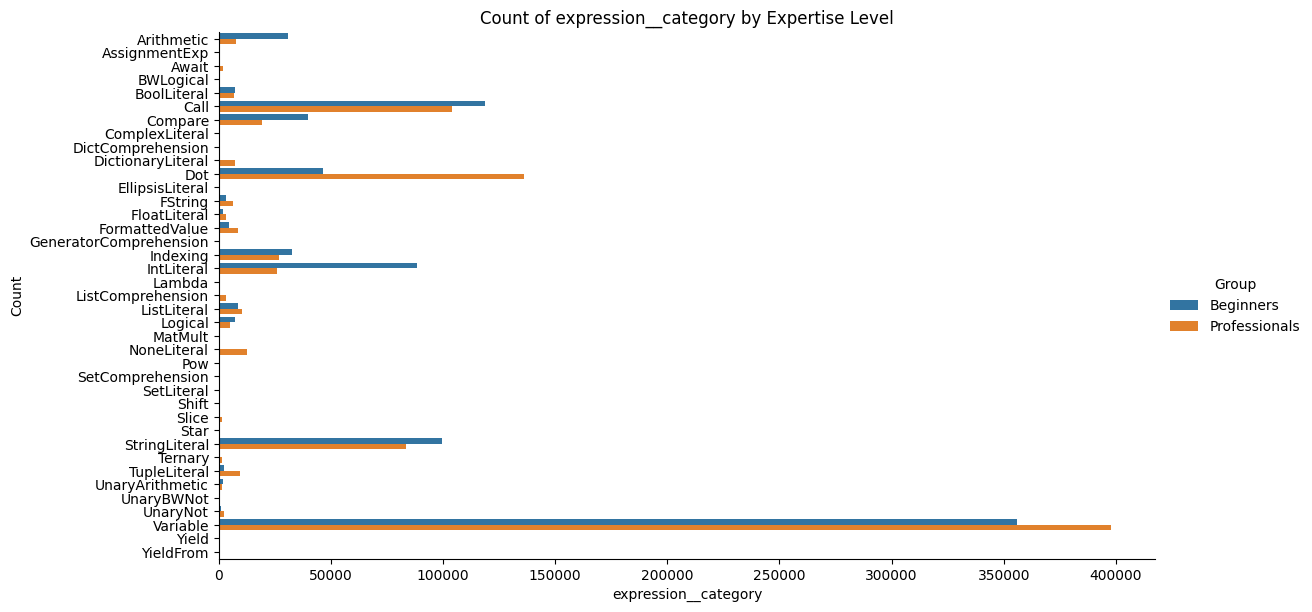

In [10]:
print_categorical_histogram(full_table, 'expression__category', TABLE_TARGET, vertical=True, include_all=False)

In [11]:
print_frequency_anal_for_cat_var(full_table, 'expression__category')

La variable expression__category contiene 39 valores distintos.
El umbral de outlier es de 0.005128205128205128%
La variable expression__category toma el valor de Variable en un 43.31% de los items.
La variable expression__category toma el valor de Call en un 12.8% de los items.
La variable expression__category toma el valor de StringLiteral en un 10.53% de los items.
La variable expression__category toma el valor de Dot en un 10.5% de los items.
La variable expression__category toma el valor de IntLiteral en un 6.551% de los items.
La variable expression__category toma el valor de Indexing en un 3.417% de los items.
La variable expression__category toma el valor de Compare en un 3.389% de los items.
La variable expression__category toma el valor de Arithmetic en un 2.211% de los items.
La variable expression__category toma el valor de ListLiteral en un 1.073% de los items.
La variable expression__category toma el valor de BoolLiteral en un 0.828% de los items.
La variable expression__

In [12]:
print_values_usage_for_cat_var(full_table, 'expression__category', EXPRESSION_CATEGORY_VALUES)

La variable expression__category puede tomar 40 valores distintos
	39 (97.5%) valores utilizados
	1 (2.5%) valores NO utilizados
		La variable expression__category nunca toma valor NoneType.


### Variable parent (2/9)
Esta variable es de tipo categorica y representa la categoria del padre de la expresion.

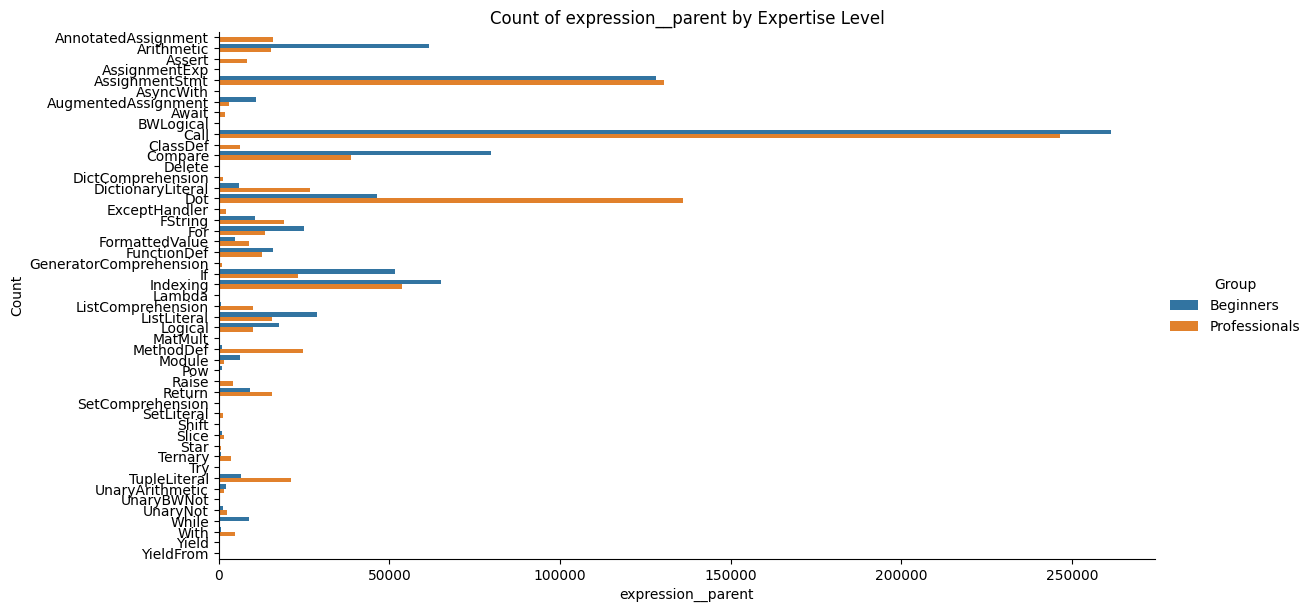

In [13]:
print_categorical_histogram(full_table, 'expression__parent', TABLE_TARGET, vertical=True, include_all=False)

In [14]:
print_frequency_anal_for_cat_var(full_table, 'expression__parent')

La variable expression__parent contiene 49 valores distintos.
El umbral de outlier es de 0.004081632653061225%
La variable expression__parent toma el valor de Call en un 29.19% de los items.
La variable expression__parent toma el valor de AssignmentStmt en un 14.86% de los items.
La variable expression__parent toma el valor de Dot en un 10.5% de los items.
La variable expression__parent toma el valor de Indexing en un 6.833% de los items.
La variable expression__parent toma el valor de Compare en un 6.81% de los items.
La variable expression__parent toma el valor de Arithmetic en un 4.421% de los items.
La variable expression__parent toma el valor de If en un 4.313% de los items.
La variable expression__parent toma el valor de ListLiteral en un 2.549% de los items.
La variable expression__parent toma el valor de For en un 2.212% de los items.
La variable expression__parent toma el valor de DictionaryLiteral en un 1.876% de los items.
La variable expression__parent toma el valor de FStr

In [15]:
print_values_usage_for_cat_var(full_table, 'expression__parent', EXPRESSION_PARENT_VALUES)

La variable expression__parent puede tomar 68 valores distintos
	49 (72.06%) valores utilizados
	19 (27.94%) valores NO utilizados
		La variable expression__parent nunca toma valor Import.
		La variable expression__parent nunca toma valor Global.
		La variable expression__parent nunca toma valor IntLiteral.
		La variable expression__parent nunca toma valor Continue.
		La variable expression__parent nunca toma valor NoneLiteral.
		La variable expression__parent nunca toma valor ComplexLiteral.
		La variable expression__parent nunca toma valor AsyncFor.
		La variable expression__parent nunca toma valor TypeAlias.
		La variable expression__parent nunca toma valor BoolLiteral.
		La variable expression__parent nunca toma valor ImportFrom.
		La variable expression__parent nunca toma valor Match.
		La variable expression__parent nunca toma valor Pass.
		La variable expression__parent nunca toma valor Variable.
		La variable expression__parent nunca toma valor StringLiteral.
		La variable expr

### Variable first_child_category (3/9)
Esta variable es de tipo categorica y representa la categoria del primer hijo de la expresion.

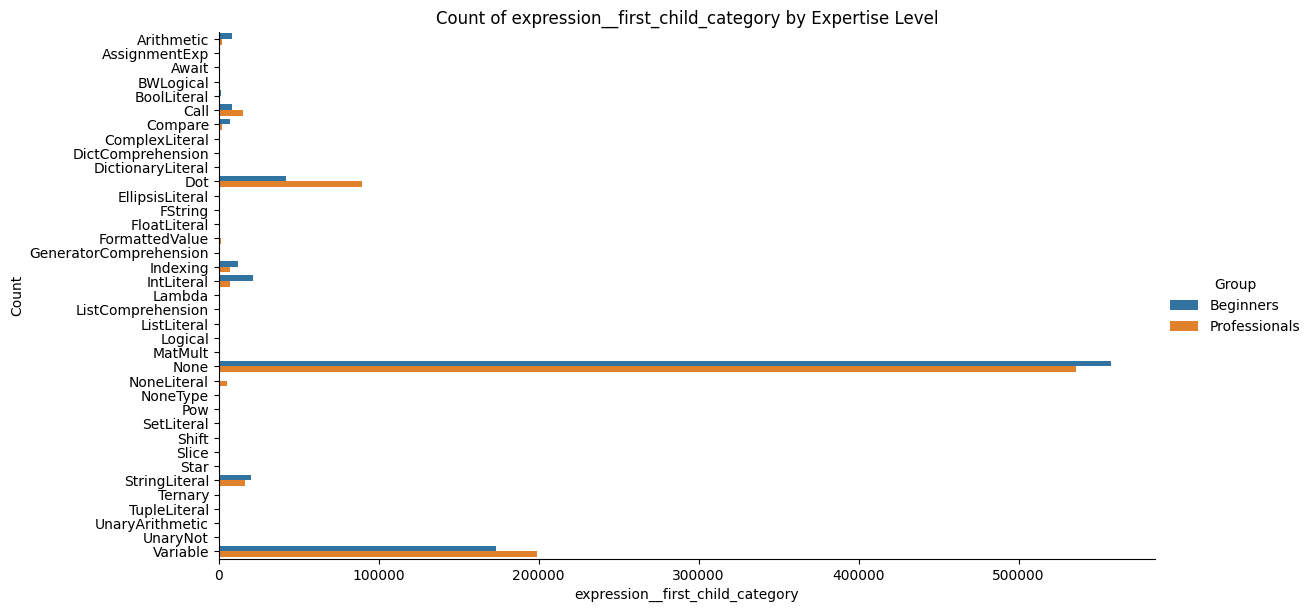

In [16]:
print_categorical_histogram(full_table, 'expression__first_child_category', TABLE_TARGET, vertical=True, fillna=True, include_all=False)

In [17]:
print_frequency_anal_for_cat_var(full_table, 'expression__first_child_category')

La variable expression__first_child_category contiene 37 valores distintos.
El umbral de outlier es de 0.005405405405405406%
La variable expression__first_child_category toma el valor de None en un 62.85% de los items.
La variable expression__first_child_category toma el valor de Variable en un 21.42% de los items.
La variable expression__first_child_category toma el valor de Dot en un 7.557% de los items.
La variable expression__first_child_category toma el valor de StringLiteral en un 2.076% de los items.
La variable expression__first_child_category toma el valor de IntLiteral en un 1.637% de los items.
La variable expression__first_child_category toma el valor de Call en un 1.334% de los items.
La variable expression__first_child_category toma el valor de Indexing en un 1.086% de los items.
La variable expression__first_child_category toma el valor de Arithmetic en un 0.6033% de los items.
La variable expression__first_child_category toma el valor de Compare en un 0.5191% de los ite

In [18]:
print_values_usage_for_cat_var(full_table, 'expression__first_child_category', EXPRESSION_CHILDREN_VALUES)

La variable expression__first_child_category puede tomar 42 valores distintos
	37 (88.1%) valores utilizados
	6 (14.29%) valores NO utilizados
		La variable expression__first_child_category nunca toma valor None.
		La variable expression__first_child_category nunca toma valor UnaryBWNot.
		La variable expression__first_child_category nunca toma valor Yield.
		La variable expression__first_child_category nunca toma valor Parameter.
		La variable expression__first_child_category nunca toma valor YieldFrom.
		La variable expression__first_child_category nunca toma valor SetComprehension.
La variable expression__first_child_category toma 1 valores desconocidos
		La variable expression__first_child_category toma valor el desconocido None.


### Variable second_child_category (4/9)
Esta variable es de tipo categorica y representa la categoria del segundo hijo de la expresion.

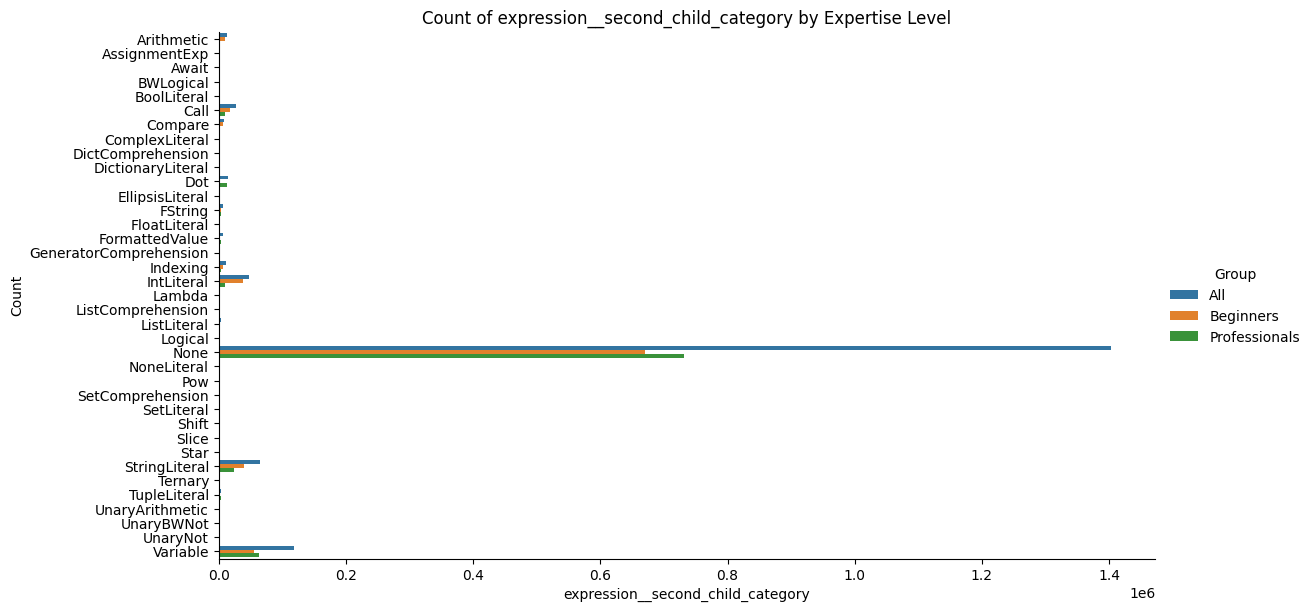

In [19]:
print_categorical_histogram(full_table, 'expression__second_child_category', TABLE_TARGET, vertical=True, fillna=True)

In [20]:
print_frequency_anal_for_cat_var(full_table, 'expression__second_child_category')

La variable expression__second_child_category contiene 37 valores distintos.
El umbral de outlier es de 0.005405405405405406%
La variable expression__second_child_category toma el valor de None en un 80.62% de los items.
La variable expression__second_child_category toma el valor de Variable en un 6.818% de los items.
La variable expression__second_child_category toma el valor de StringLiteral en un 3.687% de los items.
La variable expression__second_child_category toma el valor de IntLiteral en un 2.756% de los items.
La variable expression__second_child_category toma el valor de Call en un 1.592% de los items.
La variable expression__second_child_category toma el valor de Dot en un 0.7987% de los items.
La variable expression__second_child_category toma el valor de Arithmetic en un 0.706% de los items.
La variable expression__second_child_category toma el valor de Indexing en un 0.6644% de los items.
La variable expression__second_child_category toma el valor de Compare en un 0.4709%

In [21]:
print_values_usage_for_cat_var(full_table, 'expression__second_child_category', EXPRESSION_CHILDREN_VALUES)

La variable expression__second_child_category puede tomar 42 valores distintos
	37 (88.1%) valores utilizados
	6 (14.29%) valores NO utilizados
		La variable expression__second_child_category nunca toma valor None.
		La variable expression__second_child_category nunca toma valor NoneType.
		La variable expression__second_child_category nunca toma valor Yield.
		La variable expression__second_child_category nunca toma valor Parameter.
		La variable expression__second_child_category nunca toma valor YieldFrom.
		La variable expression__second_child_category nunca toma valor MatMult.
La variable expression__second_child_category toma 1 valores desconocidos
		La variable expression__second_child_category toma valor el desconocido None.


### Variable third_child_category (5/9)
Esta variable es de tipo categorica y representa la categoria del tercer hijo de la expresion.

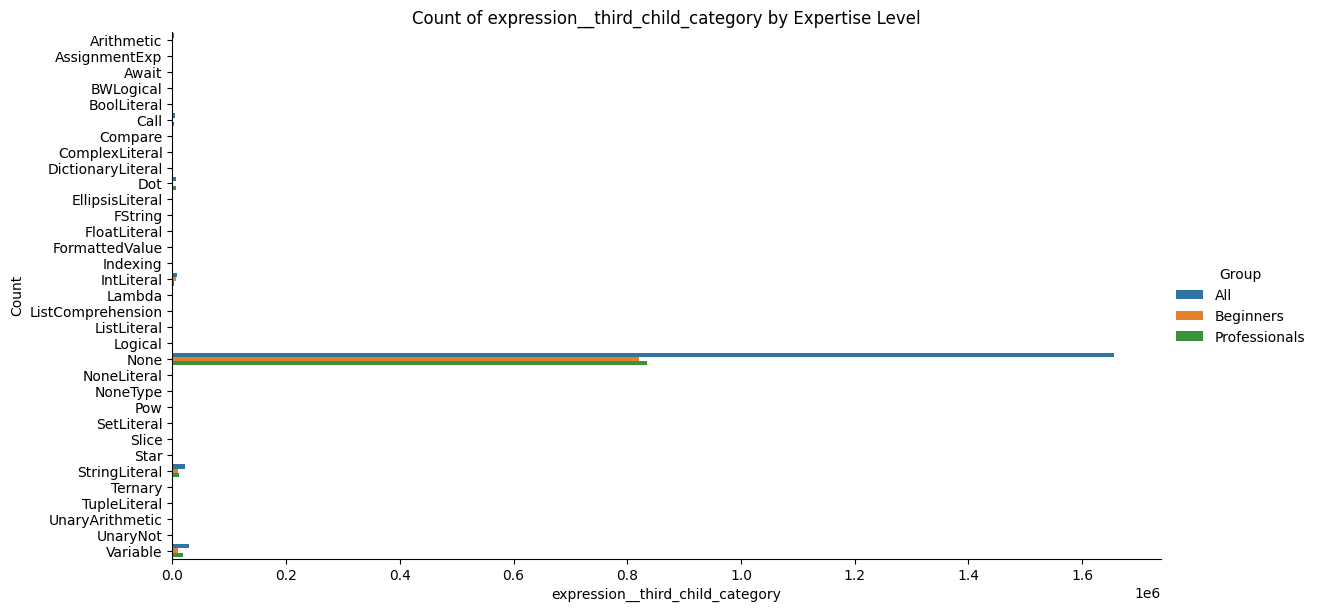

In [22]:
print_categorical_histogram(full_table, 'expression__third_child_category', TABLE_TARGET, vertical=True, fillna=True)

In [23]:
print_frequency_anal_for_cat_var(full_table, 'expression__third_child_category')

La variable expression__third_child_category contiene 33 valores distintos.
El umbral de outlier es de 0.006060606060606061%
La variable expression__third_child_category toma el valor de None en un 95.16% de los items.
La variable expression__third_child_category toma el valor de Variable en un 1.667% de los items.
La variable expression__third_child_category toma el valor de StringLiteral en un 1.277% de los items.
La variable expression__third_child_category toma el valor de IntLiteral en un 0.4981% de los items.
La variable expression__third_child_category toma el valor de Dot en un 0.3355% de los items.
La variable expression__third_child_category toma el valor de Call en un 0.2306% de los items.
La variable expression__third_child_category toma el valor de Arithmetic en un 0.1195% de los items.
La variable expression__third_child_category toma el valor de BoolLiteral en un 0.1085% de los items.
La variable expression__third_child_category toma el valor de Indexing en un 0.09772% d

In [24]:
print_values_usage_for_cat_var(full_table, 'expression__third_child_category', EXPRESSION_CHILDREN_VALUES)

La variable expression__third_child_category puede tomar 42 valores distintos
	33 (78.57%) valores utilizados
	10 (23.81%) valores NO utilizados
		La variable expression__third_child_category nunca toma valor None.
		La variable expression__third_child_category nunca toma valor UnaryBWNot.
		La variable expression__third_child_category nunca toma valor GeneratorComprehension.
		La variable expression__third_child_category nunca toma valor Shift.
		La variable expression__third_child_category nunca toma valor DictComprehension.
		La variable expression__third_child_category nunca toma valor Yield.
		La variable expression__third_child_category nunca toma valor Parameter.
		La variable expression__third_child_category nunca toma valor YieldFrom.
		La variable expression__third_child_category nunca toma valor MatMult.
		La variable expression__third_child_category nunca toma valor SetComprehension.
La variable expression__third_child_category toma 1 valores desconocidos
		La variable expr

### Variable fourth_child_category (6/9)
Esta variable es de tipo categorica y representa la categoria del cuarto hijo de la expresion.

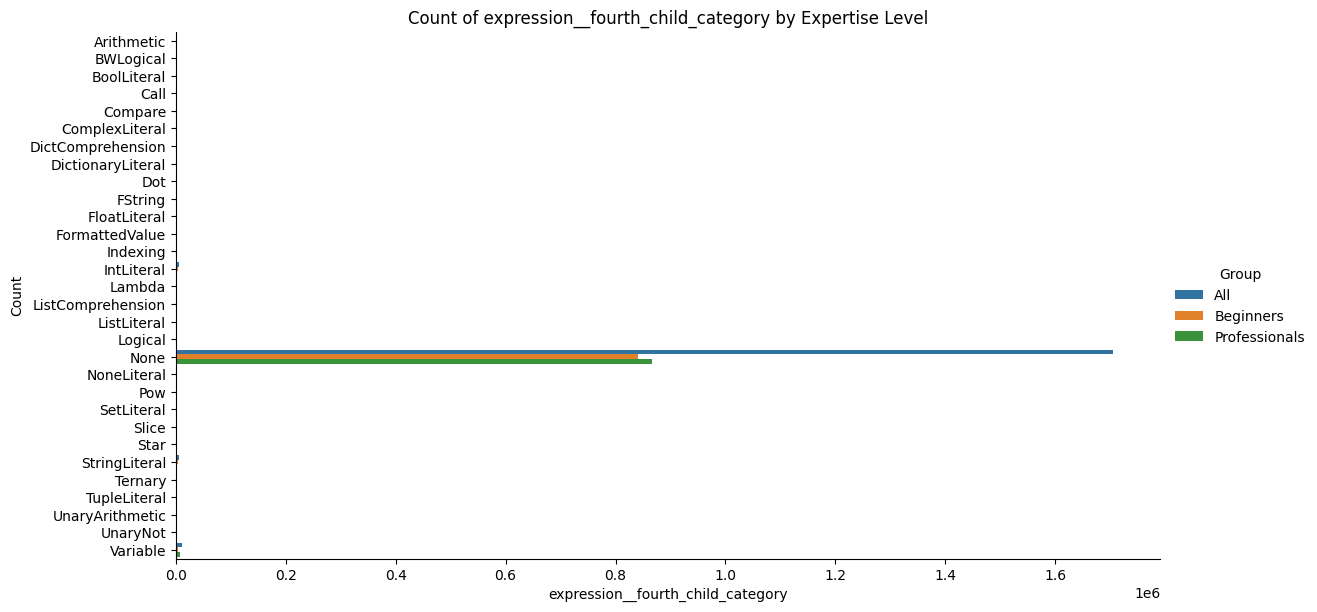

In [25]:
print_categorical_histogram(full_table, 'expression__fourth_child_category', TABLE_TARGET, vertical=True, fillna=True)

In [26]:
print_frequency_anal_for_cat_var(full_table, 'expression__fourth_child_category')

La variable expression__fourth_child_category contiene 30 valores distintos.
El umbral de outlier es de 0.006666666666666667%
La variable expression__fourth_child_category toma el valor de None en un 98.07% de los items.
La variable expression__fourth_child_category toma el valor de Variable en un 0.5953% de los items.
La variable expression__fourth_child_category toma el valor de StringLiteral en un 0.3643% de los items.
La variable expression__fourth_child_category toma el valor de IntLiteral en un 0.2772% de los items.
La variable expression__fourth_child_category toma el valor de Dot en un 0.1486% de los items.
La variable expression__fourth_child_category toma el valor de FormattedValue en un 0.1293% de los items.
La variable expression__fourth_child_category toma el valor de Call en un 0.0949% de los items.
La variable expression__fourth_child_category toma el valor de Compare en un 0.04616% de los items.
La variable expression__fourth_child_category toma el valor de DictionaryLi

In [27]:
print_values_usage_for_cat_var(full_table, 'expression__fourth_child_category', EXPRESSION_CHILDREN_VALUES)

La variable expression__fourth_child_category puede tomar 42 valores distintos
	30 (71.43%) valores utilizados
	13 (30.95%) valores NO utilizados
		La variable expression__fourth_child_category nunca toma valor None.
		La variable expression__fourth_child_category nunca toma valor AssignmentExp.
		La variable expression__fourth_child_category nunca toma valor UnaryBWNot.
		La variable expression__fourth_child_category nunca toma valor EllipsisLiteral.
		La variable expression__fourth_child_category nunca toma valor NoneType.
		La variable expression__fourth_child_category nunca toma valor GeneratorComprehension.
		La variable expression__fourth_child_category nunca toma valor Shift.
		La variable expression__fourth_child_category nunca toma valor Yield.
		La variable expression__fourth_child_category nunca toma valor Parameter.
		La variable expression__fourth_child_category nunca toma valor YieldFrom.
		La variable expression__fourth_child_category nunca toma valor MatMult.
		La varia

### Variable expression_role (7/9)
Esta variable es de tipo categorica y representa el rol de la expresion en su padre.

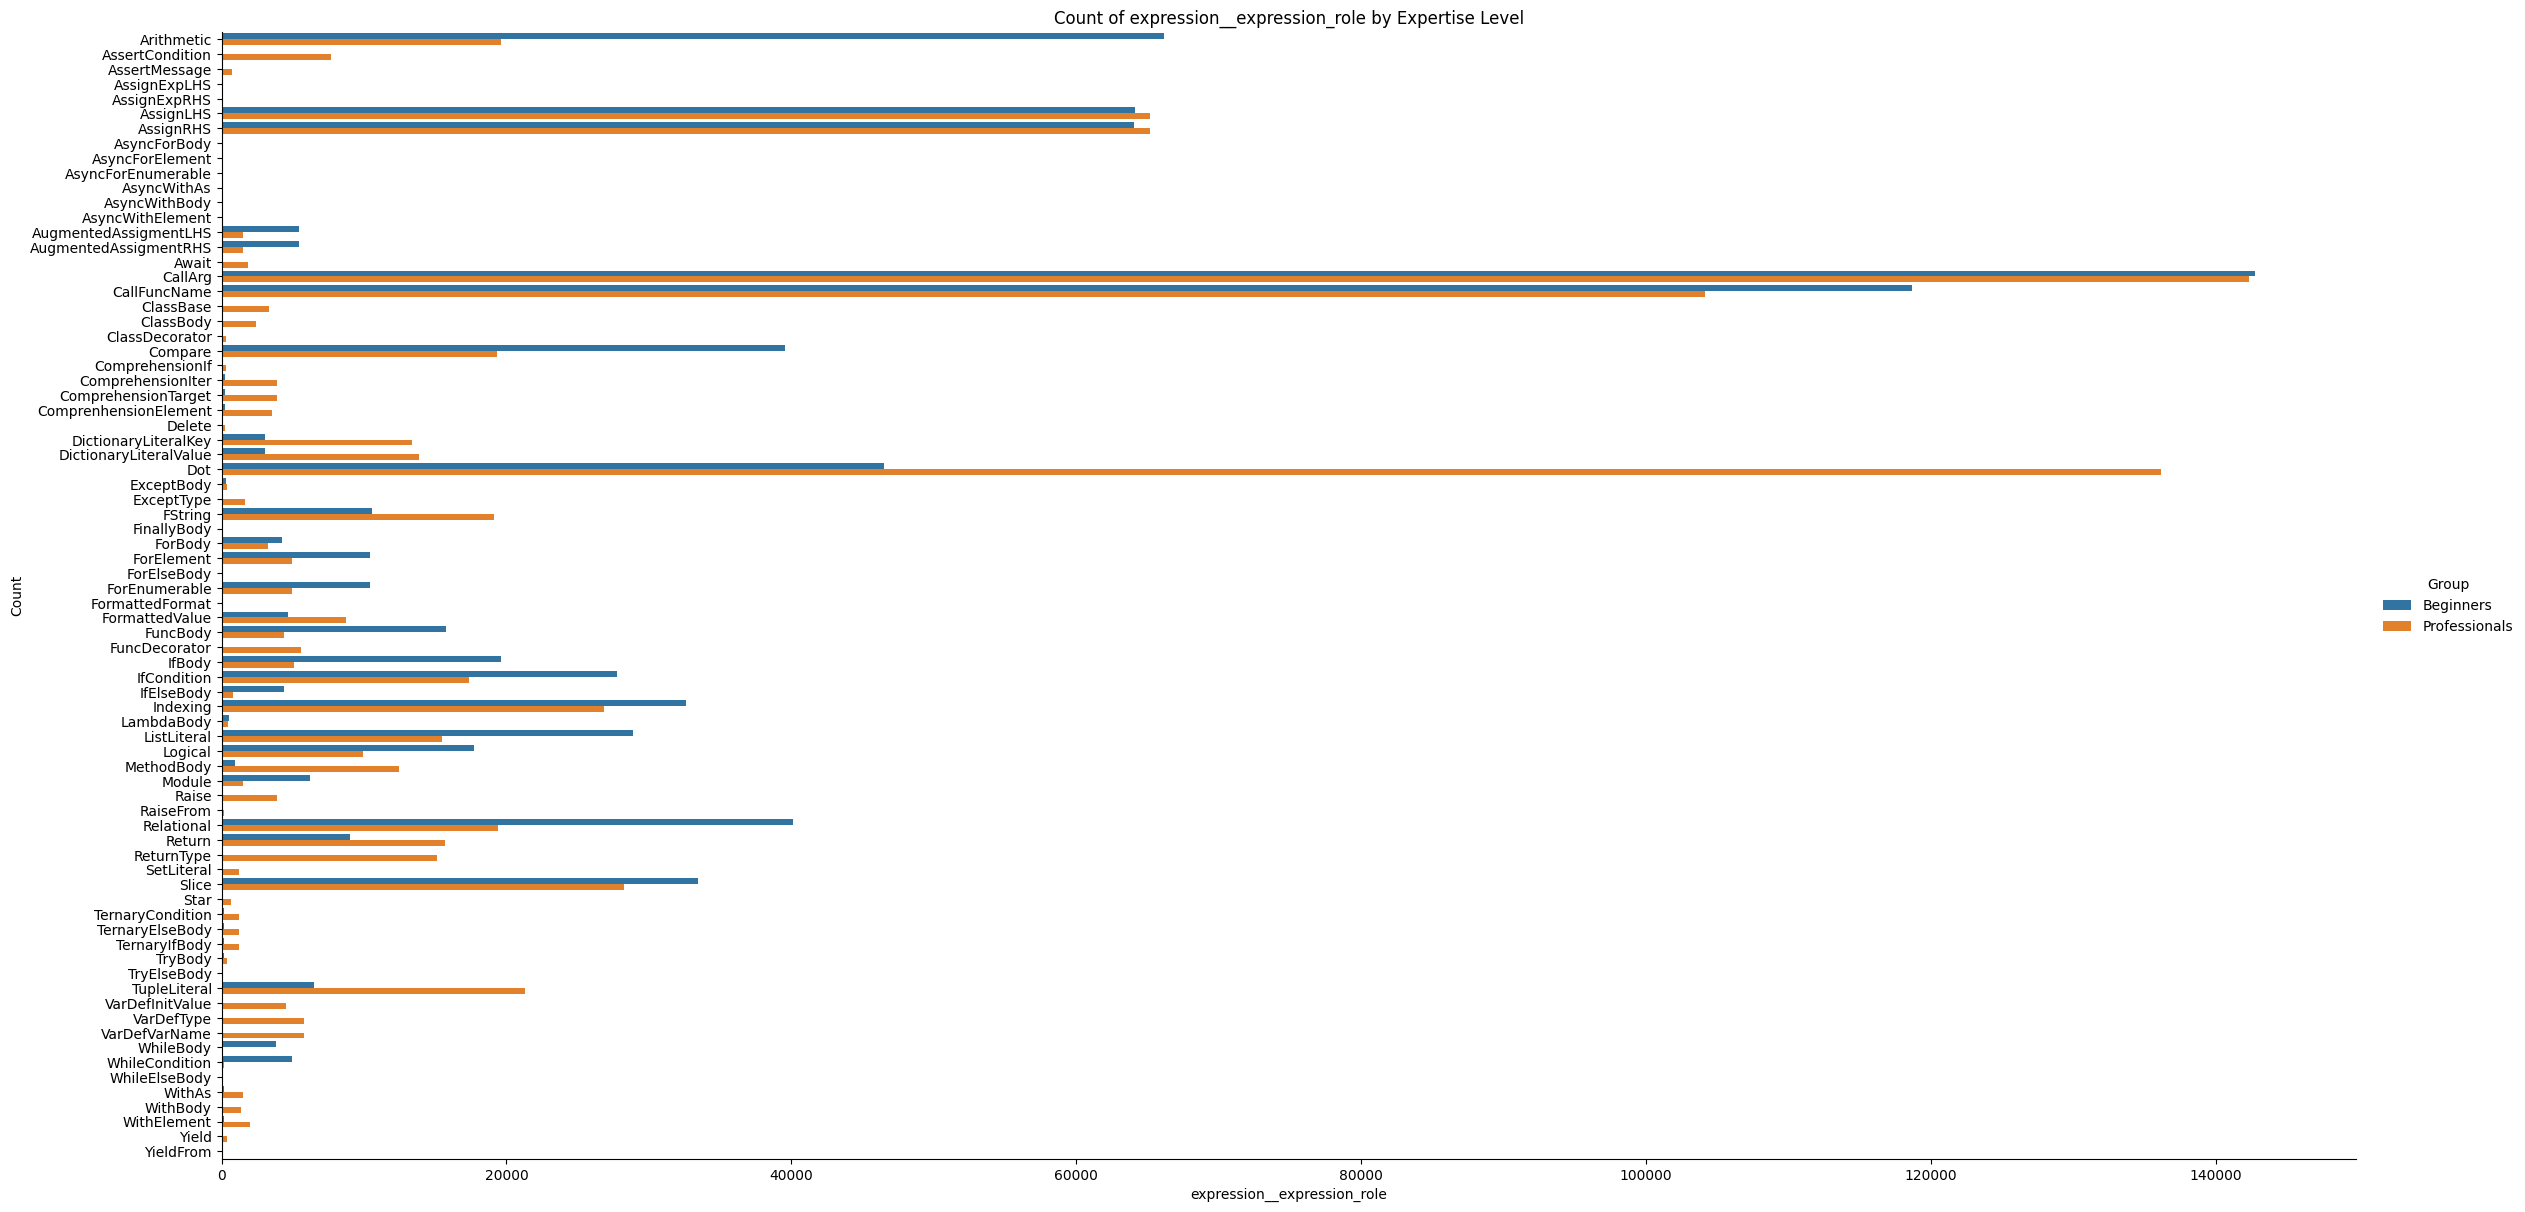

In [28]:
print_categorical_histogram(full_table, 'expression__expression_role', TABLE_TARGET, vertical=True, fillna=True, include_all=False, height = 12)

In [29]:
print_frequency_anal_for_cat_var(full_table, 'expression__expression_role')

La variable expression__expression_role contiene 76 valores distintos.
El umbral de outlier es de 0.002631578947368421%
La variable expression__expression_role toma el valor de CallArg en un 16.38% de los items.
La variable expression__expression_role toma el valor de CallFuncName en un 12.8% de los items.
La variable expression__expression_role toma el valor de Dot en un 10.5% de los items.
La variable expression__expression_role toma el valor de AssignLHS en un 7.432% de los items.
La variable expression__expression_role toma el valor de AssignRHS en un 7.428% de los items.
La variable expression__expression_role toma el valor de Arithmetic en un 4.93% de los items.
La variable expression__expression_role toma el valor de Slice en un 3.546% de los items.
La variable expression__expression_role toma el valor de Relational en un 3.421% de los items.
La variable expression__expression_role toma el valor de Indexing en un 3.417% de los items.
La variable expression__expression_role toma 

In [30]:
print_values_usage_for_cat_var(full_table, 'expression__expression_role', EXPRESSION_ROLE_VALUES)

La variable expression__expression_role puede tomar 96 valores distintos
	76 (79.17%) valores utilizados
	20 (20.83%) valores NO utilizados
		La variable expression__expression_role nunca toma valor AugmentedAssignmentLHS.
		La variable expression__expression_role nunca toma valor CaseCondition.
		La variable expression__expression_role nunca toma valor TypeAliasRHS.
		La variable expression__expression_role nunca toma valor TryElse.
		La variable expression__expression_role nunca toma valor Pow.
		La variable expression__expression_role nunca toma valor MatchCondition.
		La variable expression__expression_role nunca toma valor BWLogical.
		La variable expression__expression_role nunca toma valor CaseGuard.
		La variable expression__expression_role nunca toma valor Is.
		La variable expression__expression_role nunca toma valor CaseBody.
		La variable expression__expression_role nunca toma valor In.
		La variable expression__expression_role nunca toma valor TypeVar.
		La variable expres

### Variable height (8/9)
Esta variable representa la distancia de la expresión al root del módulo (fichero). Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 1 - 83. Con una media de 5.21.

<Axes: ylabel='expression__height'>

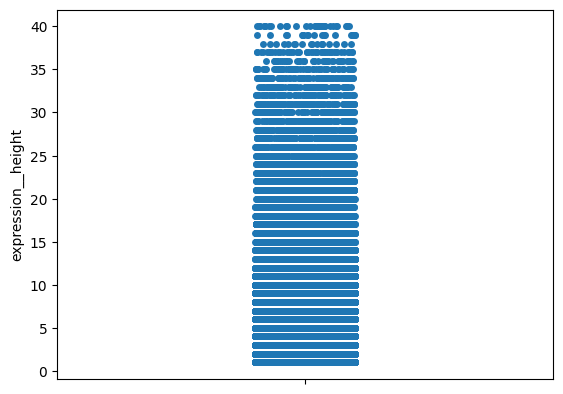

In [31]:
sns.stripplot(X['expression__height'])

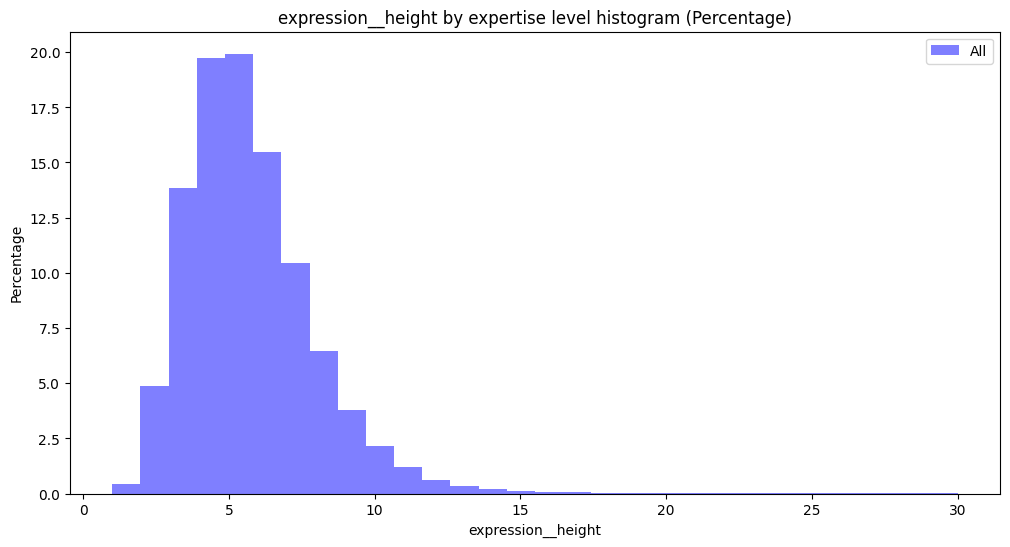

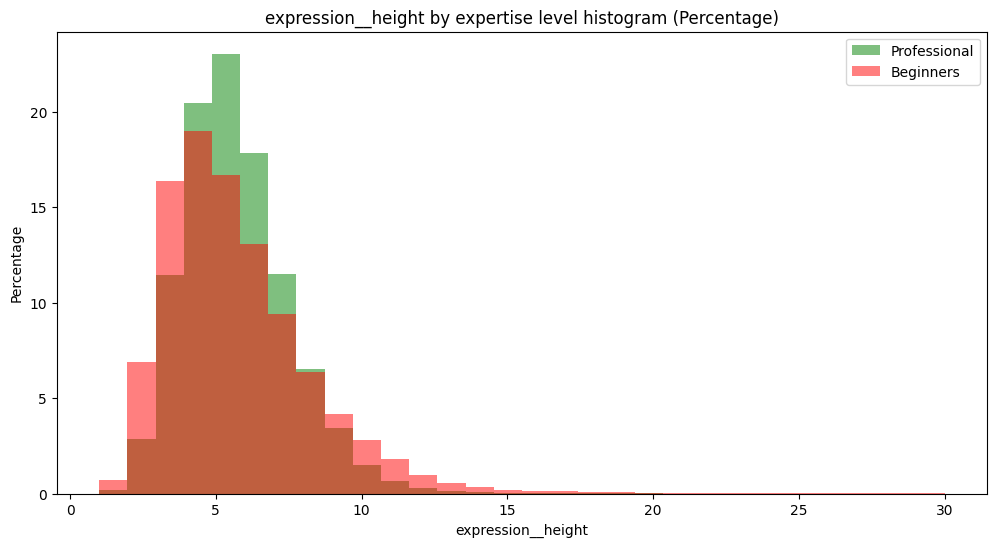

In [32]:
print_histogram(X, 'expression__height', 'expression__expertise_level', bins=30, include_beginners=False,max_value=30, include_experts=False)
print_histogram(X, 'expression__height', 'expression__expertise_level', bins=30, include_all=False, max_value=30)

In [33]:
print_outliers_for_df_column(X, 'expression__height')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.7882653872172039
Rango valores atípicos extremos (Tukey): [-5.0,16.0]
Rango valores atípicos leves (Tukey): [-0.5,11.5]
Rango valores atípicos extremos (Fixed BoxPlot): [3.7148818030316635,112.33428352078792]
-3.0IQR: 0 instancias tienen un valor para expression__height inferior a -5.0 (Q1-3*IQR) para expression__height. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para expression__height inferior a -0.5 (Q1-1.5*IQR) para expression__height. Representando un 0.0% del total de instancias.
+1.5IQR: 29202 instancias tienen un valor para expression__height superior a 11.5 (Q3+1.5*IQR) para expression__height. Representando un 1.679% del total de instancias.
+3.0IQR: 5629 instancias tienen un valor para expression__height superior a 16.0 (Q3-3*IQR) para expression__height. Representando un 0.3236% del total de instancias.
L: 333152 instancias tienen un valor para expression__height inferior a

In [34]:
X[X['expression__height'] > 12].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,expression__height,expression__depth,expression__category_Arithmetic,expression__category_AssignmentExp,expression__category_Await,expression__category_BWLogical,expression__category_BoolLiteral,expression__category_Call,expression__category_Compare,expression__category_ComplexLiteral,...,expression__expression_role_WhileBody,expression__expression_role_WhileCondition,expression__expression_role_WhileElseBody,expression__expression_role_WithAs,expression__expression_role_WithBody,expression__expression_role_WithElement,expression__expression_role_Yield,expression__expression_role_YieldFrom,expression__expertise_level_BEGINNER,expression__expertise_level_PROFESSIONAL
count,18460.000000,18460.000000,18460.000000,18460.0,18460.0,18460.0,18460.000000,18460.000000,18460.000000,18460.0,...,18460.000000,18460.000000,18460.0,18460.0,18460.0,18460.0,18460.0,18460.0,18460.000000,18460.000000
mean,16.460293,0.542741,0.045016,0.0,0.0,0.0,0.005092,0.076761,0.047237,0.0,...,0.000163,0.000704,0.0,0.0,0.0,0.0,0.0,0.0,0.851083,0.148917
std,4.913367,1.068520,0.207345,0.0,0.0,0.0,0.071179,0.266218,0.212152,0.0,...,0.012747,0.026529,0.0,0.0,0.0,0.0,0.0,0.0,0.356016,0.356016
min,13.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
25%,13.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000
50%,15.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000
75%,17.000000,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000
max,40.000000,16.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,...,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000


### Variable depth (9/9)
Esta variable representa la distancia desde la expresion hasta una hoja del ast. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 0 - 81. Con una media de 0.60.

<Axes: ylabel='expression__depth'>

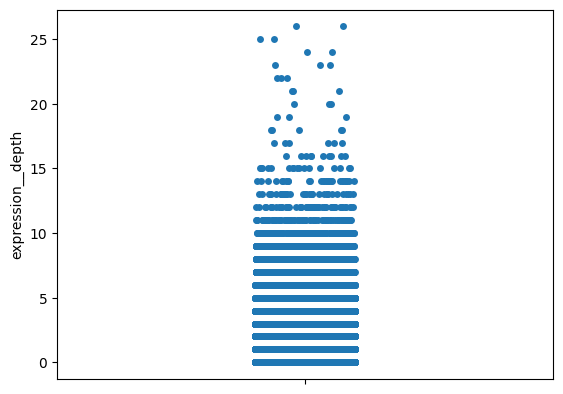

In [35]:
sns.stripplot(X['expression__depth'])

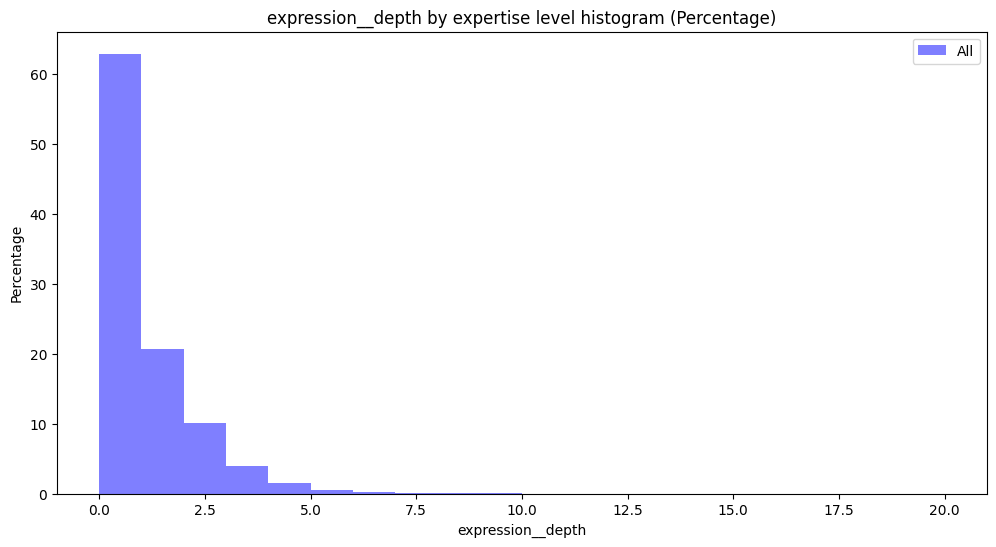

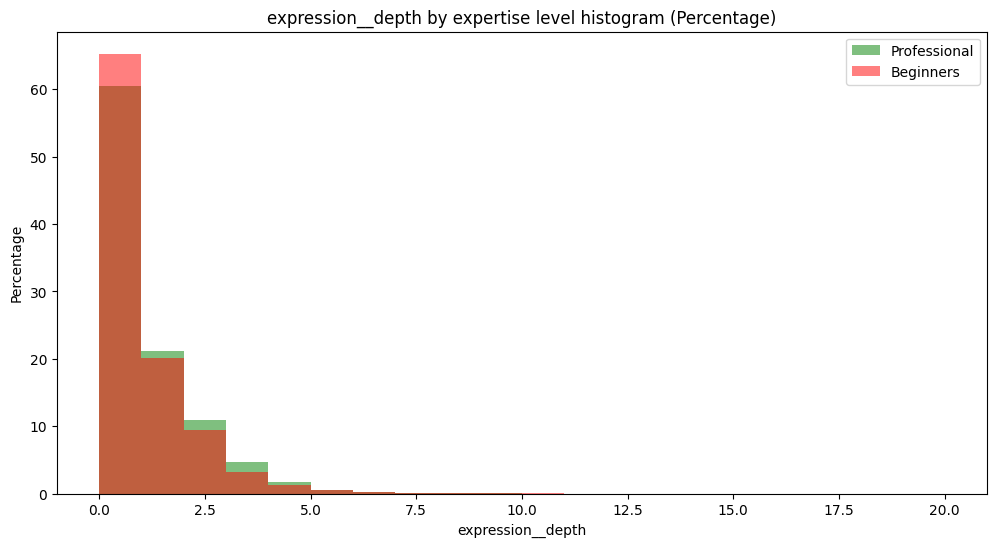

In [36]:
print_histogram(X, 'expression__depth', 'expression__expertise_level', bins=20,include_beginners=False, include_experts=False, max_value=20)
print_histogram(X, 'expression__depth', 'expression__expertise_level', bins=20, include_all=False, max_value=20)

In [37]:
print_outliers_for_df_column(X, 'expression__depth')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.535992092338127
Rango valores atípicos extremos (Tukey): [-3.0,4.0]
Rango valores atípicos leves (Tukey): [-1.5,2.5]
Rango valores atípicos extremos (Fixed BoxPlot): [-0.22980889308558136,13.799850324524403]
-3.0IQR: 0 instancias tienen un valor para expression__depth inferior a -3.0 (Q1-3*IQR) para expression__depth. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para expression__depth inferior a -1.5 (Q1-1.5*IQR) para expression__depth. Representando un 0.0% del total de instancias.
+1.5IQR: 110539 instancias tienen un valor para expression__depth superior a 2.5 (Q3+1.5*IQR) para expression__depth. Representando un 6.354% del total de instancias.
+3.0IQR: 15464 instancias tienen un valor para expression__depth superior a 4.0 (Q3-3*IQR) para expression__depth. Representando un 0.8889% del total de instancias.
L: 0 instancias tienen un valor para expression__depth inferior a -0.22980889308

In [38]:
X[X['expression__depth'] > 4].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,expression__height,expression__depth,expression__category_Arithmetic,expression__category_AssignmentExp,expression__category_Await,expression__category_BWLogical,expression__category_BoolLiteral,expression__category_Call,expression__category_Compare,expression__category_ComplexLiteral,...,expression__expression_role_WhileBody,expression__expression_role_WhileCondition,expression__expression_role_WhileElseBody,expression__expression_role_WithAs,expression__expression_role_WithBody,expression__expression_role_WithElement,expression__expression_role_Yield,expression__expression_role_YieldFrom,expression__expertise_level_BEGINNER,expression__expertise_level_PROFESSIONAL
count,15464.000000,15464.000000,15464.000000,15464.0,15464.000000,15464.000000,15464.0,15464.000000,15464.000000,15464.0,...,15464.000000,15464.000000,15464.0,15464.0,15464.000000,15464.000000,15464.000000,15464.0,15464.000000,15464.000000
mean,5.188632,5.780070,0.176733,0.0,0.015261,0.001293,0.0,0.436627,0.077988,0.0,...,0.003621,0.008213,0.0,0.0,0.001875,0.002069,0.000905,0.0,0.468314,0.531686
std,2.284249,1.501449,0.381455,0.0,0.122594,0.035941,0.0,0.495984,0.268161,0.0,...,0.060070,0.090254,0.0,0.0,0.043266,0.045444,0.030076,0.0,0.499011,0.499011
min,1.000000,5.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,4.000000,5.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,5.000000,5.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1.000000
75%,6.000000,6.000000,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.000000,1.000000
max,24.000000,26.000000,1.000000,0.0,1.000000,1.000000,0.0,1.000000,1.000000,0.0,...,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


## Multivariate

Isolation forest algorithm

In [39]:
from sklearn.ensemble import  IsolationForest

CONTAMINATION_FACTOR = 0.0012
isof_model = IsolationForest(contamination=CONTAMINATION_FACTOR, random_state=0)
isof_prediction = isof_model.fit_predict(X.values)
mask = isof_prediction == -1
full_table.loc[X.index[mask]]

,expression__expression_id,expression__category,expression__parent,expression__first_child_category,expression__second_child_category,expression__third_child_category,expression__fourth_child_category,expression__expression_role,expression__height,expression__depth,expression__expertise_level
3349,337823,DictionaryLiteral,DictionaryLiteral,StringLiteral,StringLiteral,StringLiteral,DictionaryLiteral,DictionaryLiteralValue,5,2,PROFESSIONAL
4506,336476,DictionaryLiteral,DictionaryLiteral,StringLiteral,StringLiteral,StringLiteral,DictionaryLiteral,DictionaryLiteralValue,4,2,PROFESSIONAL
5137,335753,DictionaryLiteral,DictionaryLiteral,StringLiteral,StringLiteral,StringLiteral,DictionaryLiteral,DictionaryLiteralValue,4,2,PROFESSIONAL
5606,335173,DictionaryLiteral,DictionaryLiteral,StringLiteral,BoolLiteral,StringLiteral,IntLiteral,DictionaryLiteralValue,5,2,PROFESSIONAL
5617,335179,ListLiteral,DictionaryLiteral,IntLiteral,IntLiteral,IntLiteral,IntLiteral,DictionaryLiteralValue,6,1,PROFESSIONAL
...,...,...,...,...,...,...,...,...,...,...,...
1734756,2059431,ListLiteral,AssignmentStmt,StringLiteral,StringLiteral,StringLiteral,StringLiteral,AssignRHS,2,1,BEGINNER
1734869,2059829,ListLiteral,AssignmentStmt,StringLiteral,StringLiteral,StringLiteral,StringLiteral,AssignRHS,2,1,BEGINNER
1735741,2060653,ListLiteral,AssignmentStmt,StringLiteral,StringLiteral,StringLiteral,StringLiteral,AssignRHS,2,1,BEGINNER
1735799,2060878,ListLiteral,AssignmentStmt,StringLiteral,StringLiteral,StringLiteral,StringLiteral,AssignRHS,2,1,BEGINNER


In [40]:
# Outliers
np.transpose(X[mask].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int']))

,count,mean,std,min,25%,50%,75%,max
expression__height,1968.0,3.808943,1.857967,2.0,2.0,3.0,5.0,11.0
expression__depth,1968.0,1.361280,0.861576,1.0,1.0,1.0,1.0,7.0
expression__category_Arithmetic,1968.0,0.006098,0.077868,0.0,0.0,0.0,0.0,1.0
expression__category_AssignmentExp,1968.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
expression__category_Await,1968.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
expression__expression_role_WithElement,1968.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
expression__expression_role_Yield,1968.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
expression__expression_role_YieldFrom,1968.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
expression__expertise_level_BEGINNER,1968.0,0.611281,0.487583,0.0,0.0,1.0,1.0,1.0


In [41]:
# Non-Outliers
np.transpose(X[~mask].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int']))

,count,mean,std,min,25%,50%,75%,max
expression__height,1737675.0,5.417200,2.401944,1.0,4.0,5.0,7.0,40.0
expression__depth,1737675.0,0.638737,1.056197,0.0,0.0,0.0,1.0,26.0
expression__category_Arithmetic,1737675.0,0.022123,0.147084,0.0,0.0,0.0,0.0,1.0
expression__category_AssignmentExp,1737675.0,0.000016,0.003942,0.0,0.0,0.0,0.0,1.0
expression__category_Await,1737675.0,0.001124,0.033515,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
expression__expression_role_WithElement,1737675.0,0.001270,0.035616,0.0,0.0,0.0,0.0,1.0
expression__expression_role_Yield,1737675.0,0.000222,0.014883,0.0,0.0,0.0,0.0,1.0
expression__expression_role_YieldFrom,1737675.0,0.000019,0.004358,0.0,0.0,0.0,0.0,1.0
expression__expertise_level_BEGINNER,1737675.0,0.490870,0.499917,0.0,0.0,0.0,1.0,1.0


# Escalado de los datos
Para poder aplicar los posteriores algoritmos o técnicas de forma más eficiente, vamos a escalar todos los datos con un RobustScaler, poco sensible a outliers.

In [43]:
from sklearn.preprocessing import RobustScaler

scaler_rob = RobustScaler()
scaler_rob.fit(X)
X = pd.DataFrame(scaler_rob.transform(X), columns=X.columns, index=X.index)

# Clustering
Primero calculamos el número de clusters que maximiza el silhouette score.

In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 10 + 1):
    kmeans = KMeans(n_clusters=k, random_state=0)
    clusters = kmeans.fit_predict(X)
    score = silhouette_score(X, clusters)
    silhouette_scores.append(score)
# Plot the silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(range(2, 10 + 1), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()

score_per_k = list(enumerate(silhouette_scores, 2))
print("Silhouette Scores (k, score):", score_per_k)
# k is set to the maximum value
n_clusters = max(score_per_k, key=lambda x: x[1])[0]
print(f"Optimal number of clusters: {n_clusters}.")

KeyboardInterrupt: 

D:\Usuarios\abel\AppData\Local\Temp\ipykernel_10732\3258445947.py:9: UserWarning: 
The palette list has fewer values (6) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=df_tsne[:, 0], y=df_tsne[:, 1], hue=clusters, palette=palette, legend='full', alpha=0.5)


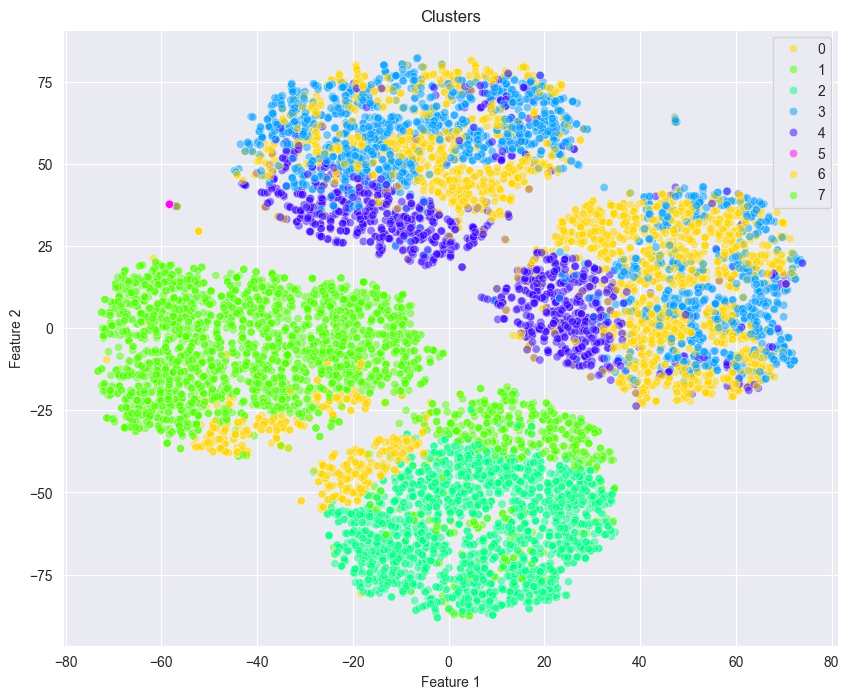

In [57]:
tsne = TSNE(n_components=2, random_state=42)
df_tsne = tsne.fit_transform(X_processed)

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_processed)

plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", 6)
sns.scatterplot(x=df_tsne[:, 0], y=df_tsne[:, 1], hue=clusters, palette=palette, legend='full', alpha=0.5)
plt.title("Clusters")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

D:\Usuarios\abel\AppData\Local\Temp\ipykernel_10732\3567923383.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y[clusters == cluster], bins=2, label=f'Cluster {cluster}', hist=False)
D:\Usuarios\abel\AppData\Local\Temp\ipykernel_10732\3567923383.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750

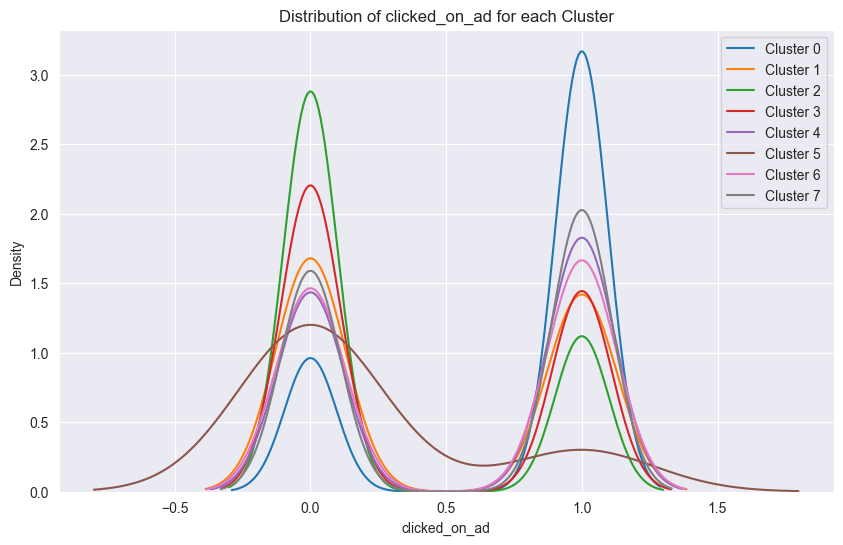

In [58]:
plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    sns.distplot(y[clusters == cluster], bins=2, label=f'Cluster {cluster}', hist=False)
plt.title(f'Distribution of clicked_on_ad for each Cluster')
plt.xlabel('clicked_on_ad')
plt.ylabel('Density')
plt.legend()
plt.show()